In [2]:
import json
import os, shutil
from ovejero import model_trainer, hierarchical_inference
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib

def NOTIMPLEMENTED():
    raise NotImplementedError('Must specify config/save path')

2023-09-17 23:06:53.972369: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-17 23:06:54.657305: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/parlange/anaconda3/envs/bnn/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Hierarchical Inference on a Test Set

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 08/15/2020

__Goals:__ Learn how to run hierarchical inference on a test set using a trained BNN

__Before running this notebook:__ Train a model and generate a test set on which you want to run hiearchical inference.

To run hierarchical inference first we need to specify the path to the config files we'll use. There are three required configs for hierarchical inference:

1. The ovejero bnn config used for training/validation/testing

2. The ovejero distribution config that specifies the hyperparameters we'll run hierarchical inference over. For an example see the config in configs/baobab_configs/cent_narrow_cfg_prior.py.

3. The baobab config used to geneate the training set.

You can also optionally specify the baobab config used to generate the test set. This will be used to plot the true values of the hyperparameters you're trying to infer.

In [12]:
# These are also optional, but these are the names of the hyperparameters and parameters of the lens sample.
# They will only be used in plotting.
hyperparam_plot_names = [r'$\mu_{\log(\gamma_\mathrm{ext})}$',r'$\sigma_{\log(\gamma_\mathrm{ext})}$',
                         r'$\mu_x$',r'$\sigma_x$',r'$\mu_y$',r'$\sigma_y$',
                         r'$\mu_{e1}$',r'$\sigma_{e1}$',
                         r'$\mu_{e2}$',r'$\sigma_{e2}$',
                         r'$\mu_{\log (\gamma_\mathrm{lens})}$',r'$\sigma_{\log (\gamma_\mathrm{lens})}$',
                         r'$\mu_{\log (\theta_E)}$',r'$\sigma_{\log (\theta_E)}$']
param_plot_names = [r'$\gamma_\mathrm{ext}$', r'$\psi_\mathrm{ext}$',r'$x_\mathrm{lens}$',
            r'$y_\mathrm{lens}$',r'$e_1$',r'$e_2$',r'$\gamma_\mathrm{lens}$',r'$\theta_E$']

# The config path used to train the BNN
bnn_config_path = '/home/parlange/ovejero/test/test_data/diag.json'
bnn_cfg = model_trainer.load_config(bnn_config_path)

def recursive_str_checker(cfg_dict):
    for key in cfg_dict:
        if isinstance(cfg_dict[key],str):
            cfg_dict[key] = cfg_dict[key].replace('/home/swagnercarena/ovejero/', '/home/parlange/ovejero/')
        if isinstance(cfg_dict[key],dict):
            recursive_str_checker(cfg_dict[key])
recursive_str_checker(bnn_cfg)

# The baobab config used to generate the training set.
interim_baobab_omega_path = '/home/parlange/ovejero/test/test_data/test_baobab_cfg.py'

# The ovejero distribution config specifying the hyperparameters you want to fit.
target_ovejero_omega_path = '/home/parlange/ovejero/configs/baobab_configs/test_ovejero_cfg_prior.py'

# Optional, but you can also specify the baobab config used to generate the test set.
target_baobab_omega_path = '/home/parlange/ovejero/test/test_data/test_baobab_cfg_target.py'

# The path to the test dataset
test_dataset_path = '/home/parlange/ovejero/test/test_data/'

# The path to which the tf record will be saved
test_dataset_tf_record_path = '/home/parlange/ovejero/test/test_data/record/'

# The number of walkers to use in the hierarchical inference. This should be AT LEAST double the number of
# hyperparameters that are being inferred.
n_walkers = 50

# If you've already generated the samples you can set this to True. If you do, the weights won't be
# loaded, avoiding memory errors.
lite_class = False

# The HierarchicalClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the test dataset, and providing outputs correctly marginalized over the BNN uncertainties.
# To initialize it we need to pass in our config files
hier_infer = hierarchical_inference.HierarchicalClass(bnn_cfg,interim_baobab_omega_path,target_ovejero_omega_path,
                                                      test_dataset_path,test_dataset_tf_record_path,
                                                      target_baobab_omega_path=target_baobab_omega_path,
                                                      lite_class=lite_class)

Is model built: True
Loaded weights /home/parlange/ovejero/test/test_data/test_model.h5
TFRecord found at /home/parlange/ovejero/test/test_data/tf_record_test_val
Generating new TFRecord at /home/parlange/ovejero/test/test_data/record/


100%|██████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1363.91it/s]


After we've initialized our class, we need to generate bnn samples for the lenses in our test set.

In [13]:
# A path where the BNN samples will be saved
#save_path_samples = '/home/parlange/ovejero/hierarchical_results_upload/cn_nn1_hr_samps/'
save_path_samples = '/home/parlange/ovejero/test/test_data/bnnsamples/'

# The number of BNN samples to draw per lens
num_samples = 1000

# This command will generate the samples on the test set
hier_infer.gen_samples(num_samples, save_path_samples)

Loading samples from /home/parlange/ovejero/test/test_data/bnnsamples/
Loading samples from /home/parlange/ovejero/test/test_data/bnnsamples/


Now we can run the hierarchical inference. We have to specify the number of walkers and the path to save the emcee samples to. We'll pick a specific path for the demo that we'll clear out later.

In [14]:
# Number of walkers
n_walkers = 50

# The path to save the emcee samples to
save_path_chains_hr = '/home/parlange/ovejero/test/test_data/demo_hier_samples.h5'

# Initialize the sampler
hier_infer.initialize_sampler(n_walkers,save_path_chains_hr)

Loaded chains found at /home/parlange/ovejero/test/test_data/demo_hier_samples.h5


Finally, we can run our hierarchical inference. For 100 steps this should take a few minutes (less when you have more cores)

In [15]:
# We can run the sampler for 100 steps.
num_emcee_samples = 1000
hier_infer.run_sampler(num_emcee_samples,progress=True)

100%|████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.37it/s]


100 steps isn't enough for convergence, but we can still inspect the chains. The HierarchicalInference class allows us to plot the chains and to do some basic autocorrelation analysis. Neither plot should make you feel like things have converged in 100 steps.

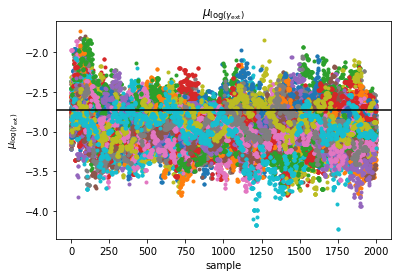

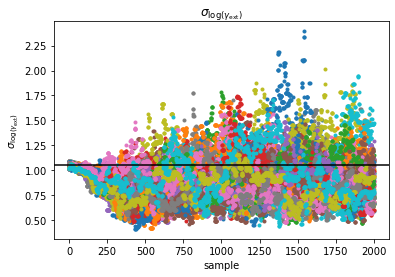

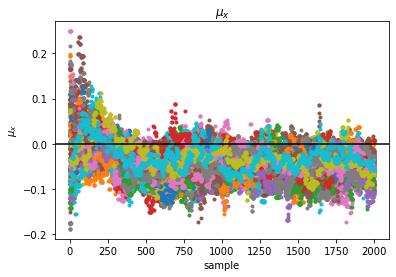

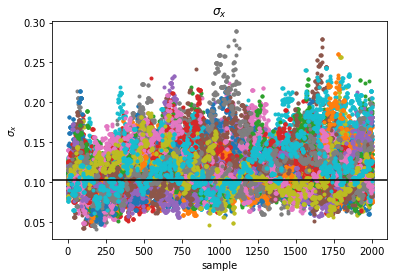

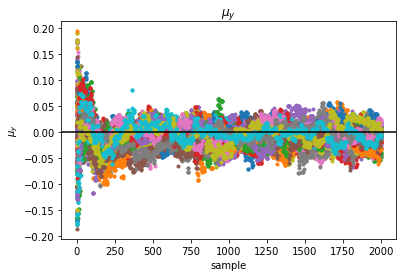

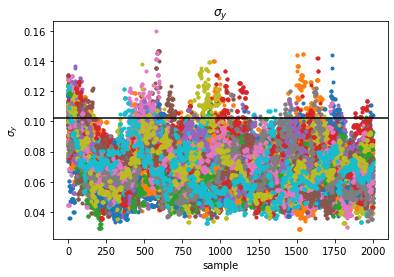

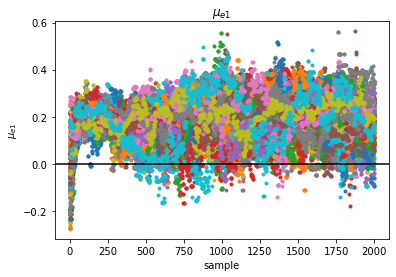

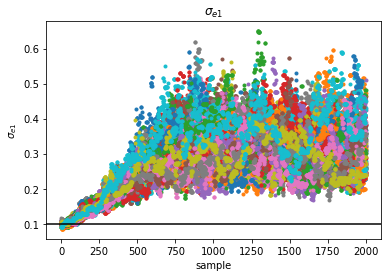

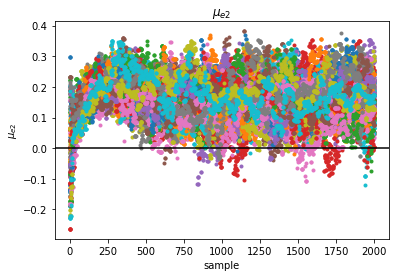

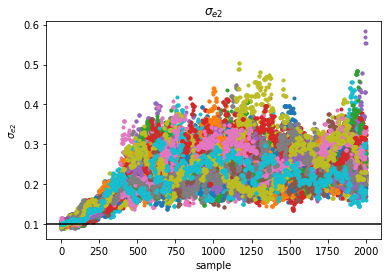

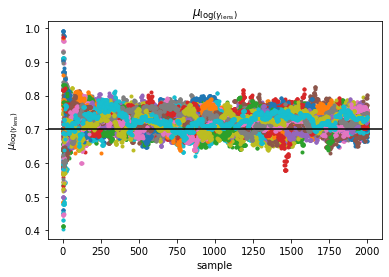

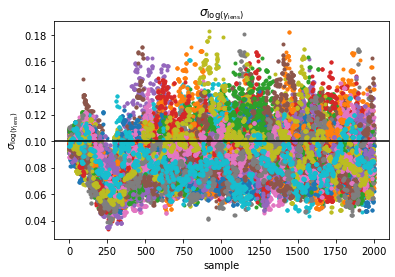

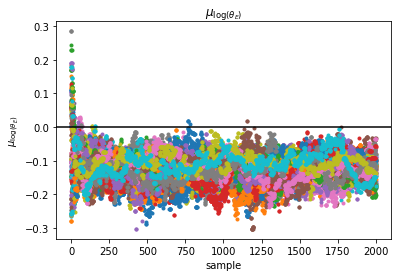

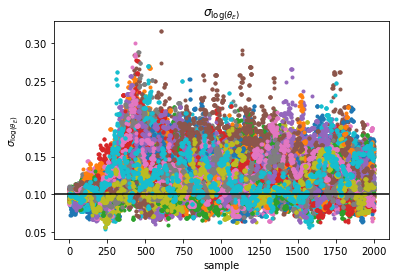

In [16]:
burnin = 0
hier_infer.plot_chains(burnin=burnin,hyperparam_plot_names=hyperparam_plot_names)

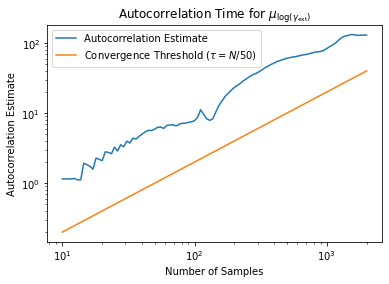

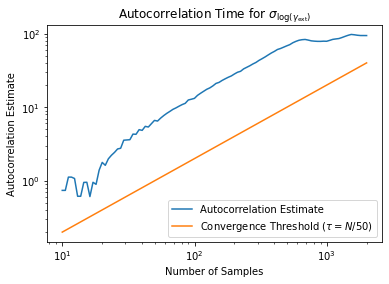

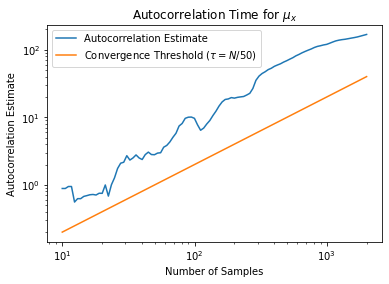

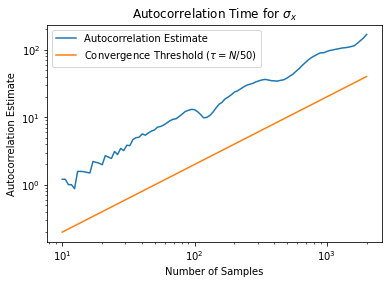

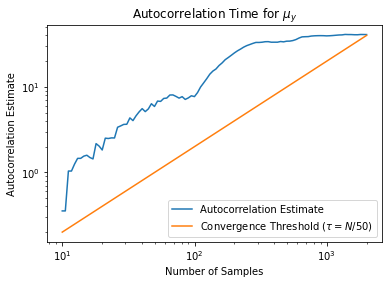

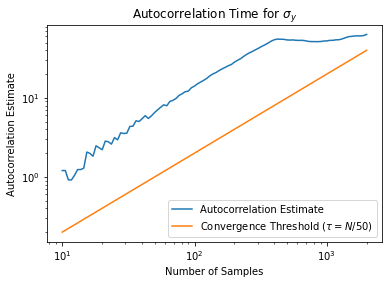

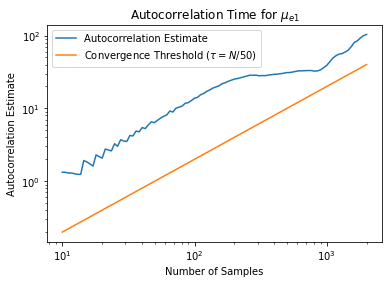

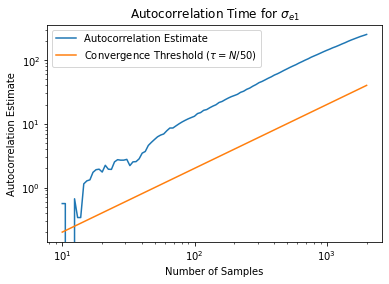

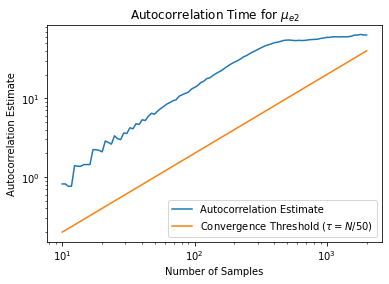

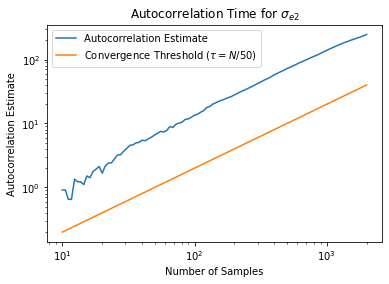

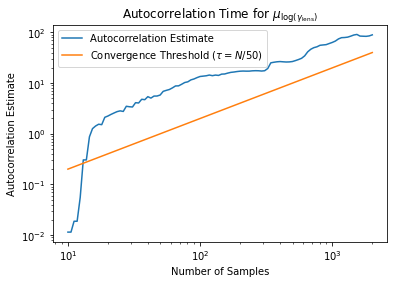

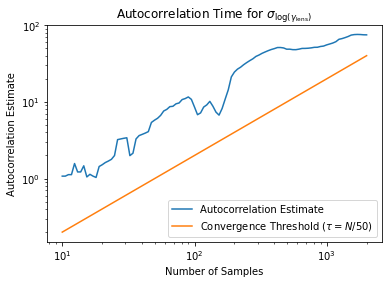

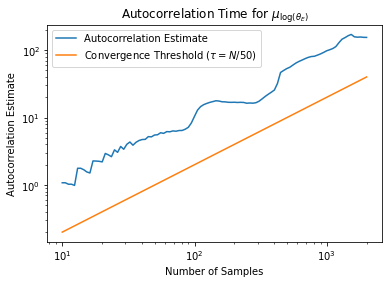

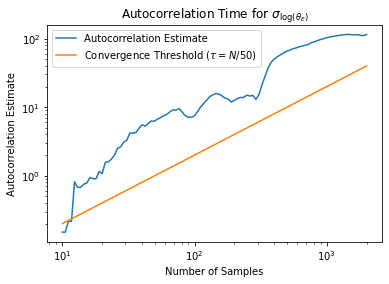

In [17]:
hier_infer.plot_auto_corr(hyperparam_plot_names=hyperparam_plot_names)

The class also allows us to inspect the results of the hierarchical inference and generate some nice plots. For an example check the hierarchical inference notebook in the papers folder.

In [ ]:
# Delete the weights we generated.
os.remove('demo_hier_samples.h5')
shutil.rmtree('fow_model_bnn_samps')